# 1. Homomorphic Encryption Basics

**Note:** This notebook adapts [original material](https://github.com/OpenMined/TenSEAL) by the TenSEAL developers. 

Homomorphic Encryption (HE) enables **arithmetic computations to be performed on encrypted data**. Ideally, computations over encrypted data should correspond exactly to their unencrypted counterparts. The following diagram illustrates this concept over the addition of two numbers. 

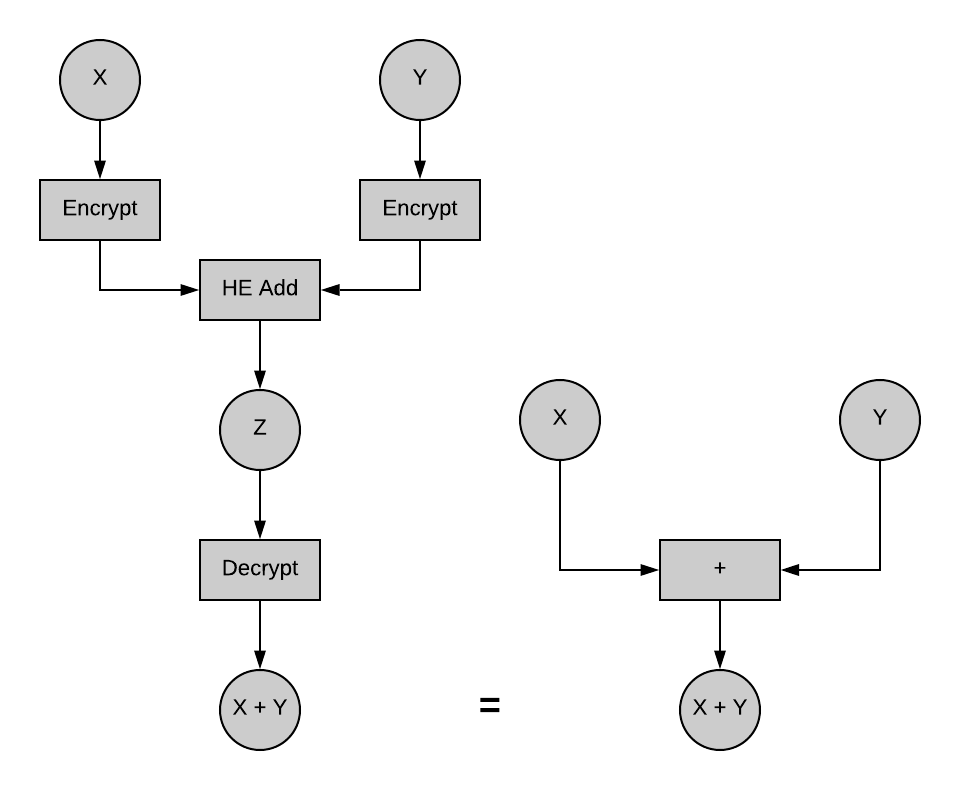

In practice, **encrypted arithmetic operations may result in precision loss**, especially for floating point arithmetic. Privacy, precision, and computational tradeoffs are explored in this notebook.

## 1.1 Data Types and Arithmetic Operations

In general, **HE does not support all arithmetic computations**. Popular HE packages like [Microsoft's SEAL](https://github.com/microsoft/SEAL) implement limited arithmetic operations, namely **addition and multiplication** over integer and floating point values, from an algebraic point of view. 

In this series of notebooks, we will explore [OpenMined's TenSEAL](https://github.com/OpenMined/TenSEAL), a Python package for vector and tensor computations that extends SEAL.

### 1.1.1 TenSEAL Data Types

The following data types are used for arithmetic computations in TenSEAL:

- **BFVVector** - for 1D integer arrays.
- **CKKSVector** - for 1D float arrays.
- **CKKSTensor** - for N-dimensional float arrays with support for reshaping and broadcasting.

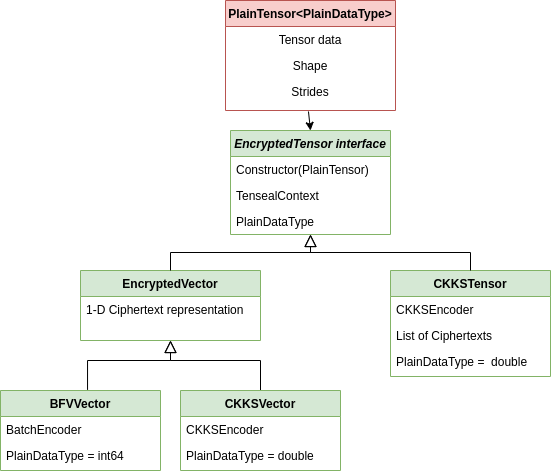


### 1.1.2 Encrypted Tensor Operations

The following table enumerates standard arithmetic operations supported by TenSEAL's CKKSTensor objects.

| Operation                    | Description                                                   |
| --- | --- |
| negate                       | Negate an encrypted tensor                                    |
| square                       | Compute the square of an encrypted tensor                     |
| power                        | Compute the power of an encrypted tensor                      |
| add                          | Addition between two encrypted tensors                        |
| add\_plain                   | Addition between an encrypted tensor and a plain tensor       |
| sub                          | Subtraction between two encrypted tensors                     |
| sub\_plain                   | Subtraction between an encrypted tensor and a plain tensor    |
| **mul**                          | **Multiplication between two encrypted tensors**                  |
| **mul\_plain**                   | **Multiplication between an encrypted tensor and a plain tensor** |
| dot                 | Dot product between two encrypted tensors                     |
| dot\_plain          | Dot product between an encrypted tensor and a plain tensor    |
| **polyval**                      | **Polynomial evaluation with an encrypted tensor as variable**    |
| **matmul**                | **Multiplication between an encrypted vector and a plain matrix** |
| matmul\_plain           | Encrypted matrix multiplication with plain vector             |


As we can see, TenSEAL supports **mixed arithmetic operations** between unencrypted and encrypted tensors. This is very useful for applications in machine learning (ML). 

## 1.2 HE in Machine Learning

In ML, there are serveral use cases for which encryption could improve security or privacy. These include:

- **Encrypted Inference**
- Encrypted Model Training
- Secure Computation as Part of Other PETs

Since our focus is on PETs for neural networks, we need support for precise floating point arithmetic. Before exploring encrypted ML using a multi-layer perceptron (MLP) model for breast cancer risk prediction (see [HE_Private_MLP.ipynb](HE_Private_MLP.ipynb)), let's first explore the use of TenSEAL for basic encrypted arithmetic.

# 2 Floating Point Arithmetic in TenSEAL

In order to use TenSEAL properly, it is important to understand its core encryption object and parameters.

## 2.1 Theory: CKKS scheme

**Cheon-Kim-Kim-Song (CKKS)** is a scheme for Leveled Homomorphic Encryption that supports approximate arithmetics over complex numbers (hence, real numbers).
 
A high-level overview of the CKKS scheme is presented in the following diagram:

<img src="https://blog.openmined.org/content/images/2020/08/Cryptotree_diagrams-2.svg" alt="ckks-high-level" width="600"/>


## 2.2 CKKS Encryption Parameters

#### Parameter 1: The scaling factor (global_scale)
The first step of the CKKS encryption scheme is to encode a vector of real numbers into a plaintext polynomial.

The **scaling factor** defines the encoding precision for the binary representation of numbers. Intuitively, we are talking about binary precision as pictured below:

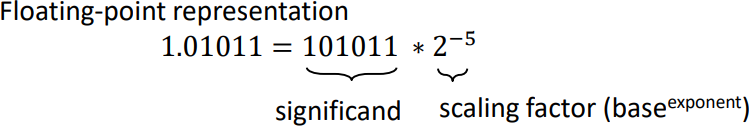

#### Parameter 2: The polynomial modulus degree (poly_modulus_degree)

The polynomial modulus($N$ in the diagram) directly affects:
 - The number of coefficients in plaintext polynomials
 - The size of ciphertext elements
 - The computational performance of the scheme (bigger is worse)
 - The security level (bigger is better).

In TenSEAL, as in Microsoft SEAL, **the degree of the polynomial modulus must be a power of 2**.

#### Parameter 3: The coefficient modulus sizes (coeff_mod_bit_sizes)

The last parameter required for the scheme is a list of binary sizes.
Using this list, SEAL will generate a list of primes of those binary sizes, called the coefficient modulus($q$ in the diagram).

The coefficient modulus directly affects:
 - The size of ciphertext elements
 - **The length of the list indicates the level of the scheme (or the number of encrypted multiplications supported)**.
 - The security level (bigger is worse).
 
In TenSEAL, as in Microsoft SEAL, each of the prime numbers in the **coefficient modulus must be at most 60 bits and must be congruent to 1 modulo 2*poly_modulus_degree**.

## 2.3 Specifying the Encryption Context

In [300]:
import tenseal as ts

def create_context(
    scheme=ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree = 2**13,
    coeff_mod_bit_sizes=(60, 40, 40, 60),
    global_scale=2**40
):
    
    """
    Instantiate a TenSEAL context object. This object holds encryption parameters and keys
    needed to support floating point computations. The parameter values here are taken from 
    the TenSEAL tutorials. 
    """
    
    context = ts.context(
        scheme=scheme,
        poly_modulus_degree=poly_modulus_degree,
        coeff_mod_bit_sizes=list(coeff_mod_bit_sizes)
    )
    
    context.global_scale = global_scale
    context.generate_galois_keys()
    return context

context = create_context()

## 2.4 Arithmetic Operations and Precision Loss

In [301]:
import numpy as np

v1 = np.array([1.1, 2.2, 3.3, 4.4])
v2 = np.array([1, 1, 1, 1])

v1_enc = ts.ckks_vector(context, v1)
v2_enc = ts.ckks_vector(context, v2)

#### Number of bytes used to encode vector

In [302]:
v1_enc_bytes = v1_enc.serialize()
len(v1_enc_bytes)

334371

#### Decrypting an encrypted vector

In [303]:
v1_enc.decrypt()

[1.0999999997873098, 2.2000000011865875, 3.2999999992880875, 4.400000001833406]

#### Encrypted addition

In [305]:
(v1_enc + v2_enc).decrypt()

[2.099999999512209, 3.2000000036982295, 4.299999996926554, 5.400000003798313]

#### Encrypted subtraction

In [306]:
(v1_enc - v2_enc).decrypt()

[0.10000000006241053,
 1.1999999986749466,
 2.3000000016496216,
 3.399999999868499]

#### Encrypted Multiplication

In [309]:
(v2_enc * v2_enc).decrypt()

ValueError: scale out of bounds

#### Multiplications require larger encryption parameters

In [311]:
context = create_context(poly_modulus_degree=2**14, coeff_mod_bit_sizes=(60, 40, 40, 40, 40, 40, 40, 40, 60))

v2_enc = ts.ckks_vector(context, v2)

print((v2_enc * v2_enc).decrypt())
print((v2_enc * v2_enc * v2_enc).decrypt())
print((v2_enc * v2_enc * v2_enc * v2_enc).decrypt())
print((v2_enc * v2_enc * v2_enc * v2_enc * v2_enc).decrypt())

[1.0000014335684901, 1.0000014348389665, 1.0000014204112326, 1.0000014297655104]
[1.0000046219885086, 1.0000046233927256, 1.0000046055725278, 1.0000046215518812]
[1.0000114034431542, 1.0000114185712778, 1.0000113965232713, 1.0000114173706196]
[1.0000211554512095, 1.0000211706546964, 1.000021122953277, 1.0000211565690689]
